In [13]:
from osgeo import gdal
from osgeo import osr
import netCDF4 as nc4
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import pytz
%matplotlib inline

In [14]:
def create_tif(destName, array, fill_value, rows, cols, top_left_x, top_left_y, x_step, y_step, epsg, rotation=0):
    """
    function to create tif file
    """
    
    # Create output tiff file.
    # driver.Create() parameters are: output path, number of columns, number of rows,
    # number of bands, data type
    driver = gdal.GetDriverByName("GTiff")
    out_tif = driver.Create(destName, cols, rows, 1, gdal.GDT_Float32)

    # Create Spatial Reference object and set GeoTIFF projection.
    # This information may be found in either the data documentation or the netCDF file.
    prj = osr.SpatialReference()
    prj.ImportFromEPSG(epsg) # WGS84
    out_tif.SetProjection(prj.ExportToWkt())

    # Set GeoTransformation.
    # This information may be found in either the data documentation, the netCDF file, or
    # can be derived. For example, if you know the longitude range and number of columns
    # you can calculate the x step as float(lon_range)/float(num_cols).
    geotrans = [top_left_x, x_step, rotation, top_left_y, rotation, y_step]
    out_tif.SetGeoTransform(geotrans)

    # Finally we can write the array to the raster band.
    out_band = out_tif.GetRasterBand(1)    
    out_band.SetNoDataValue(fill_value)
    out_band.WriteArray(array)

    # Clear the memory and close the output file.
    out_tif.FlushCache()
    out_tif = None

In [15]:
# open KNMI nc file
nc_file = r'T:\2Mattijn\SPEI\NetCDF\NDB2_20000101.nc'
dataset = nc4.Dataset(nc_file)

In [16]:
# parse dates from 'time' layer
dates = np.asarray(dataset['time'])

# dates is in seconds since Unix Epoch, convert to datetime objects
list_dates = []
for date in dates:
    list_dates.append(datetime.fromtimestamp(date, pytz.timezone('GMT')))
list_dates

[datetime.datetime(2000, 1, 1, 1, 0, tzinfo=<StaticTzInfo 'GMT'>),
 datetime.datetime(2000, 1, 1, 2, 0, tzinfo=<StaticTzInfo 'GMT'>),
 datetime.datetime(2000, 1, 1, 3, 0, tzinfo=<StaticTzInfo 'GMT'>),
 datetime.datetime(2000, 1, 1, 4, 0, tzinfo=<StaticTzInfo 'GMT'>),
 datetime.datetime(2000, 1, 1, 5, 0, tzinfo=<StaticTzInfo 'GMT'>),
 datetime.datetime(2000, 1, 1, 6, 0, tzinfo=<StaticTzInfo 'GMT'>),
 datetime.datetime(2000, 1, 1, 7, 0, tzinfo=<StaticTzInfo 'GMT'>),
 datetime.datetime(2000, 1, 1, 8, 0, tzinfo=<StaticTzInfo 'GMT'>),
 datetime.datetime(2000, 1, 1, 9, 0, tzinfo=<StaticTzInfo 'GMT'>),
 datetime.datetime(2000, 1, 1, 10, 0, tzinfo=<StaticTzInfo 'GMT'>),
 datetime.datetime(2000, 1, 1, 11, 0, tzinfo=<StaticTzInfo 'GMT'>),
 datetime.datetime(2000, 1, 1, 12, 0, tzinfo=<StaticTzInfo 'GMT'>),
 datetime.datetime(2000, 1, 1, 13, 0, tzinfo=<StaticTzInfo 'GMT'>),
 datetime.datetime(2000, 1, 1, 14, 0, tzinfo=<StaticTzInfo 'GMT'>),
 datetime.datetime(2000, 1, 1, 15, 0, tzinfo=<StaticTzInf

In [17]:
# parse precipitation from 'Precipitation' layer
precip = np.asarray(dataset['Precipitation'])    
fill_value = dataset['Precipitation']._FillValue # -999

# set mask
precip_ma = np.ma.masked_where(precip==fill_value, precip)
precip_ma_day = np.ma.sum(precip_ma, axis=0)

# set fill value
precip = precip.astype(float)
precip[precip==float(fill_value)]= np.nan

# compute day sum (nansum returns np.nan as zeroes)

precip_day = np.nansum(precip, axis=0)

# add fill_value add masked locations
precip_day[precip_ma_day.mask] = fill_value

# flip the array
precip_day = np.flipud(precip_day)

In [18]:
# plot hourly images
# for idx, val in enumerate(list_dates):
#     precip_hour = np.flipud(precip_ma[idx])    

#     im = plt.imshow(precip_hour, vmin=0, vmax=40)
#     plt.colorbar(im)
#     plt.title(val.strftime('%Y-%m-%d %H:%M'))
#     plt.show()

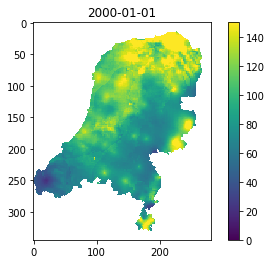

In [19]:
# plot day sum
im = plt.imshow(np.flipud(precip_ma_day), vmin=0, vmax=150)
plt.colorbar(im)
plt.title(list_dates[0].strftime('%Y-%m-%d'))
plt.show()

#### Following describes how to save the array to EPSG:29882 geotiff

In [20]:
print(dataset.comment)

Data is in RD-projection (Rijksdriehoeksstelsel).
Proj.4 string is +proj=sterea +lat_0=52.15616055555555 +lon_0=5.38763888888889 +k=0.9999079 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +no_defs +<>
Upper-left corner is at (10725,635793) in this projection.


In [21]:
# get lon/lat array
lats = dataset['y'][:]
lons = dataset['x'][:]

# get array dimensions
rows, cols = (len(lats), len(lons))

# get top-left coordinate + stepsize
top_left_x = lons.min()
top_left_y = lats.max()
x_step = lats[1] - lats[0]
y_step = -(lons[1] - lons[0])
print(top_left_x, top_left_y)

10725.0 635793.0


In [22]:
# create tmp file directory
path_out = os.path.join(r'T:\2Mattijn\SPEI\tif','ncastif.tif')
print('nc as tif : {0}'.format(path_out))

nc as tif : T:\2Mattijn\SPEI\tif\ncastif.tif


In [23]:
# write to tif in epsg 28992 projection
epsg = 28992
create_tif(path_out, precip_day, float(fill_value), rows, cols, top_left_x, top_left_y, x_step, y_step, epsg=epsg)